In [1]:
# Import
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings('ignore')
%matplotlib inline

dirpath = '../data/'

In [2]:
# Load data
customers = pd.read_csv(dirpath+"olist_customers_dataset.csv")
order_payments = pd.read_csv(dirpath+"olist_order_payments_dataset.csv")
orders = pd.read_csv(dirpath+"olist_orders_dataset.csv")
orders_item = pd.read_csv(dirpath+"olist_order_items_dataset.csv")
products = pd.read_csv(dirpath+"olist_products_dataset.csv")

# Join
customer_order = customers.merge(orders, on='customer_id', how='left')
order_payments = order_payments.groupby('order_id').sum().reset_index()[['order_id','payment_value']]
cop = customer_order.merge(order_payments, on='order_id', how='left')
cop = cop.merge(orders_item, on='order_id', how='left')
cop = cop.merge(products, on='product_id', how='left')

# clean and format
cop['order_purchase_timestamp'] = pd.to_datetime(cop['order_purchase_timestamp'])
cop = cop[cop['order_status']!='canceled']

In [3]:
test = cop.merge(cop.groupby('customer_unique_id').size().reset_index(), on='customer_unique_id', how='left')
test1 = test[test.iloc[:,-1] > 1]

In [4]:
import numpy as np
test1 = test1.groupby('customer_unique_id')['order_purchase_timestamp'].apply(lambda x: x.sort_values()).reset_index()
test1['T'] = (test1.groupby('customer_unique_id')['order_purchase_timestamp'].diff() / np.timedelta64(1, 'W'))
test1 = test1.dropna(subset=['T'])
test1['T'] = test1['T'].apply(np.ceil).astype(int)
test1 = test1[test1['T'] > 0]
test1['E'] = 1
test1 = test1[['customer_unique_id', 'order_purchase_timestamp','T','E']]

In [5]:
t_end = cop.order_purchase_timestamp.max()
test2 = test[test.iloc[:,-1] < 2]
test2['E'] = 0
test2['T'] = ((t_end - test2.order_purchase_timestamp) / np.timedelta64(1, 'W')).apply(np.ceil).astype(int)
test2 = test2[['customer_unique_id', 'order_purchase_timestamp','T','E']]

In [6]:
test2 = test2[:4000]

In [7]:
test_df = pd.concat([test1,test2])
df_full = test_df.merge(cop, on=['customer_unique_id','order_purchase_timestamp'], how='left')

df_model = df_full[['T','E','customer_state','payment_value']]
df_model = pd.get_dummies(data=df_model, columns=['customer_state'])

In [8]:
df_full.head()

,customer_unique_id,order_purchase_timestamp,T,E,customer_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,...,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,004288347e5e88a27ded2bb23747066c,2018-01-14 07:36:54,25,1,f6efe5d5c7b85e12355f9d5c3db46da2,26220,nova iguacu,RJ,08204559bebd39e09ee52dcb56d8faa2,delivered,...,87.90,15.38,malas_acessorios,39.0,278.0,1.0,700.0,19.0,48.0,35.0
1,004b45ec5c64187465168251cd1c9c2f,2018-05-26 19:42:48,39,1,d95f60d70d9ea9a7fe37c53c931940bb,57035,maceio,AL,9392c5e72885ad5aba87e6223ca9838d,delivered,...,27.00,22.85,moveis_decoracao,45.0,660.0,1.0,3450.0,23.0,35.0,35.0
2,00a39521eb40f7012db50455bf083460,2018-06-03 10:12:57,2,1,cbb68c721ba9ddb30d8a490cc1897fa1,72595,brasilia,DF,cea3e6c11eb60acb9d8d4d51694832f8,delivered,...,11.55,15.23,eletronicos,45.0,868.0,1.0,175.0,22.0,12.0,15.0
3,00cc12a6d8b578b8ebd21ea4e2ae8b27,2017-03-21 19:25:23,1,1,102fc0966044243157bb81e4ee0a251e,3178,sao paulo,SP,d61b915b69851aec8a8865f36cfd793e,delivered,...,69.90,11.88,cama_mesa_banho,52.0,534.0,1.0,700.0,45.0,15.0,35.0
4,011575986092c30523ecb71ff10cb473,2018-04-18 21:58:08,9,1,71c7265705afd84d030d6adc3122d8dd,30660,belo horizonte,MG,ed0a6265b5b0a292cd537214f401f1fc,delivered,...,63.90,16.42,instrumentos_musicais,58.0,767.0,8.0,500.0,30.0,15.0,30.0


In [9]:
df_full.product_category_name.value_counts()

cama_mesa_banho                                  903
beleza_saude                                     649
esporte_lazer                                    637
moveis_decoracao                                 583
informatica_acessorios                           540
utilidades_domesticas                            466
relogios_presentes                               409
automotivo                                       285
telefonia                                        267
brinquedos                                       257
ferramentas_jardim                               245
perfumaria                                       225
cool_stuff                                       221
fashion_bolsas_e_acessorios                      196
bebes                                            191
papelaria                                        145
eletronicos                                      140
pet_shop                                         118
moveis_escritorio                             

In [10]:
mu = df_model.payment_value.mean()
sigma = df_model.payment_value.std()
df_model.payment_value = (df_model.payment_value - mu)/sigma # standardization of data
df_model = df_model.dropna()

In [11]:
from sklearn.model_selection import train_test_split
time_column = 'T'
event_column = 'E'

N = df_model.shape[0]

index_train, index_test = train_test_split( range(N), test_size = 0.35)
data_train = df_model.loc[index_train].reset_index( drop = True )
data_test  = df_model.loc[index_test].reset_index( drop = True )

# Creating the X, T and E inputs
X_train, X_test = data_train.iloc[:,2:], data_test.iloc[:,2:]
T_train, T_test = data_train[time_column], data_test[time_column]
E_train, E_test = data_train[event_column], data_test[event_column]

In [12]:
N_null = sum(df_model.iloc[:,2:].isnull().sum())
N_dupli = sum(df_model.iloc[:,2:].duplicated(keep='first'))
print('The raw_dataset contains {} null values.'.format(N_null))
print('The dataset contains {} duplicates.'.format(N_dupli))

The raw_dataset contains 0 null values.
The dataset contains 1559 duplicates.


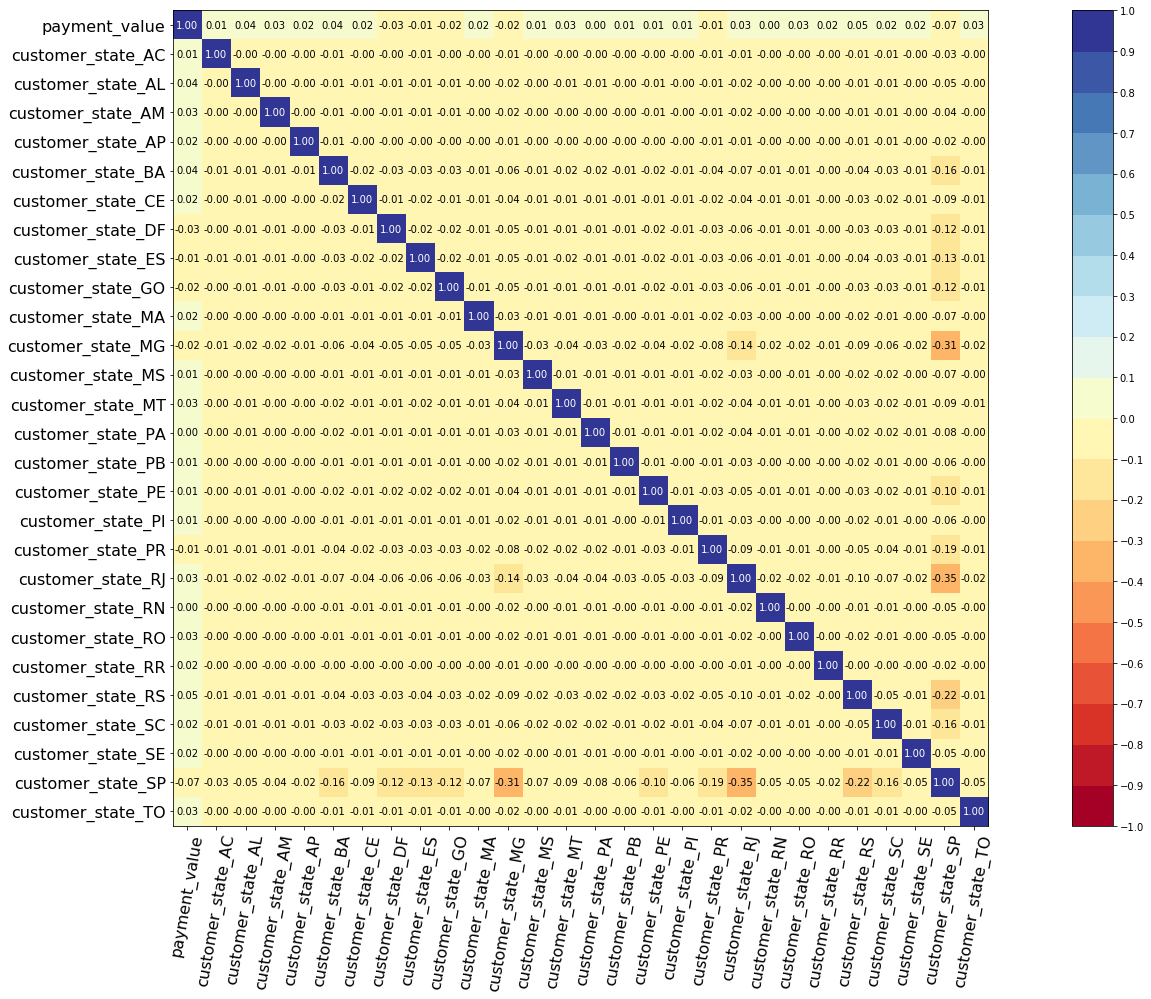

In [13]:
from pysurvival.utils.display import correlation_matrix
correlation_matrix(df_model.iloc[:,2:], figure_size=(30, 15), text_fontsize=10)

In [14]:
from pysurvival.utils.display import integrated_brier_score
from pysurvival.utils.metrics import concordance_index

In [14]:
from pysurvival.models.non_parametric import KaplanMeierModel
km = KaplanMeierModel()

In [15]:
from pysurvival.models.survival_forest import ExtraSurvivalTreesModel
xst = ExtraSurvivalTreesModel(num_trees=20) 
xst.fit(X_train, T_train, E_train,
        max_features='sqrt',
        max_depth=5,
        min_node_size=20,
        num_random_splits=20)

ExtraSurvivalTreesModel

In [16]:
print('Model name: {}'.format(xst.name))
# Print C-index
print('C-index: {:.3f}'.format(concordance_index(xst, X_train, T_train, E_train)))
print('C-index: {:.3f}'.format(concordance_index(xst, X_test, T_test, E_test)))

Model name: ExtraSurvivalTreesModel
C-index: 0.512
C-index: 0.520


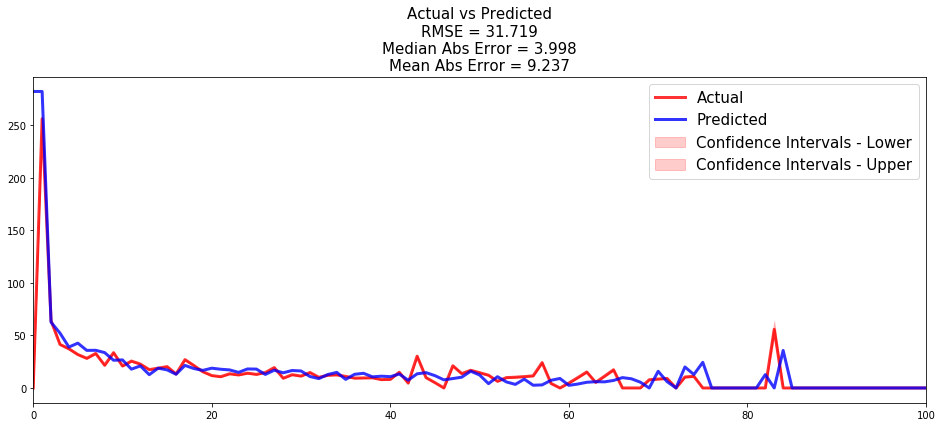

In [17]:
from pysurvival.utils.display import compare_to_actual
results = compare_to_actual(xst, X_test, T_test, E_test,
                            is_at_risk=False,
                            figure_size=(16, 6),
                            metrics=['rmse', 'mean', 'median'])

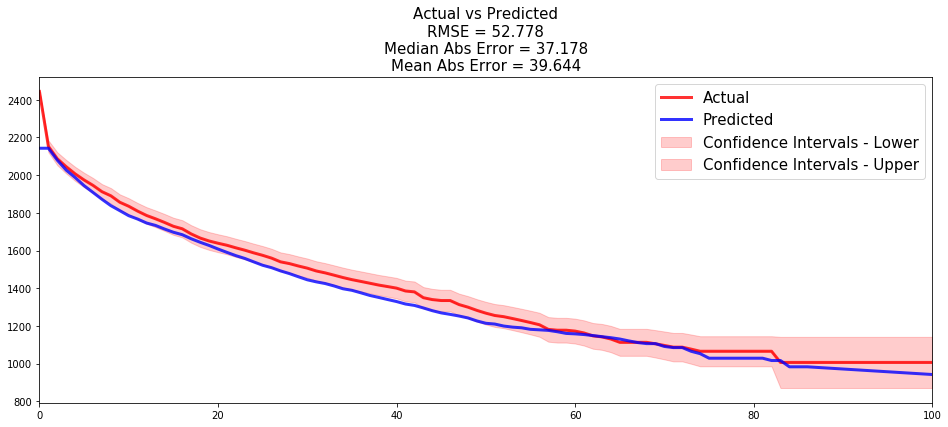

In [20]:
results = compare_to_actual(xst, X_test, T_test, E_test,
                            is_at_risk=True,
                            figure_size=(16, 6),
                            metrics=['rmse', 'mean', 'median'])

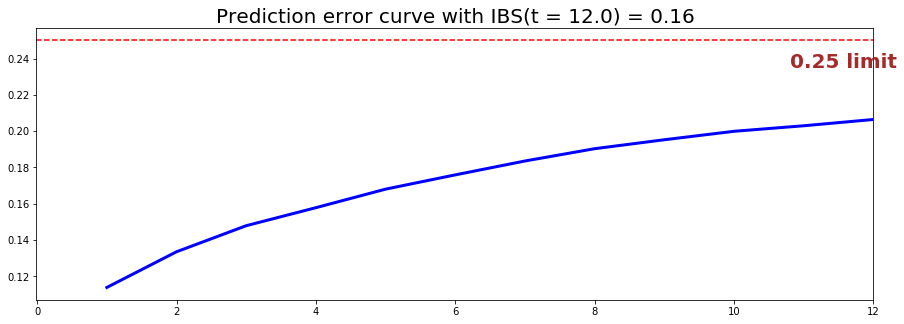

IBS: 0.160


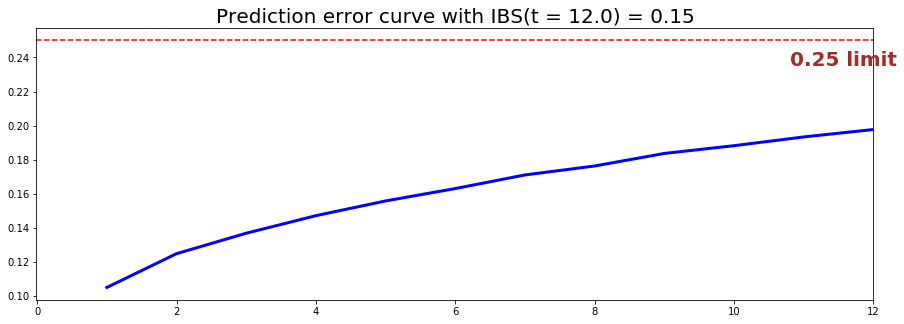

IBS: 0.149


In [18]:
# Print IBS
print('IBS: {:.3f}'.format(integrated_brier_score(xst, X_train, T_train, E_train, t_max=12, figure_size=(15, 5))))
print('IBS: {:.3f}'.format(integrated_brier_score(xst, X_test, T_test, E_test, t_max=12, figure_size=(15, 5))))

In [25]:
# Computing variables importance
xst.variable_importance_table.head(20)

,feature,importance,pct_importance
0,customer_state_GO,2.235831,0.215063
1,customer_state_PR,2.032525,0.195507
2,customer_state_CE,1.735949,0.166980
3,customer_state_MG,1.164705,0.112032
4,customer_state_PI,1.025978,0.098688
5,customer_state_SC,0.864383,0.083144
6,customer_state_MT,0.753418,0.072471
7,customer_state_PE,0.301417,0.028993
8,customer_state_SP,0.281955,0.027121
9,customer_state_AL,0.000000,0.000000


In [21]:
from pysurvival.utils.display import create_risk_groups

ValueError: The boundaries definitions [(0.0, 1.65), (1.65, 2.2), (2.2, 3.0)] do not match, the values of the risk scores.

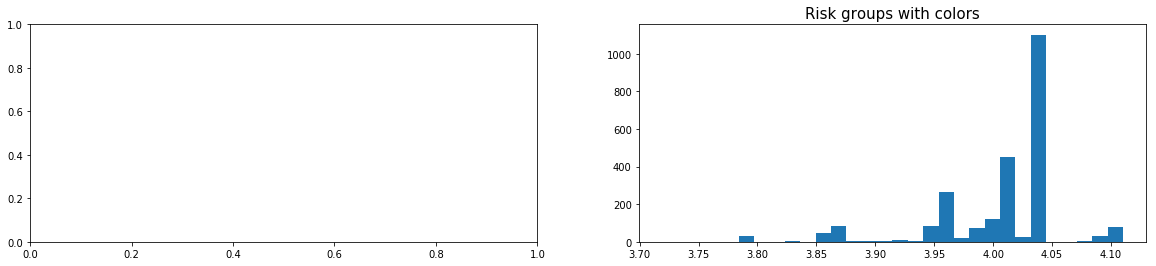

In [22]:
# Create risk groups
risk_groups = create_risk_groups(model=xst, X=X_test,
                                 use_log=True,
                                 num_bins=30,
                                 figure_size=(20, 4),
                                 low={'lower_bound': 0., 'upper_bound': 1.65, 'color': 'red'},
                                 medium={'lower_bound': 1.65, 'upper_bound': 2.2, 'color': 'green'},
                                 high={'lower_bound': 2.2, 'upper_bound': 3., 'color': 'blue'})